<h1 style="text-align:center;">Forex Trading Environment</h1>

<br>


<br>

# Import the Packages

---

In [1]:
# Import the libraries
import enum
import gym
import time
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
# Import the local libraries
from data_helper import *

In [3]:
# Show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

<br>

# Data Preparation

---

In [ ]:
# Load the dataset + Add more features
dataset = pd.read_csv("./../datasets/train/dataset.csv").reset_index()[["ticker", "time", "sell", "buy"]].sort_values(by = ["ticker", "time"])
dataset.columns = ["Ticker", "Timestep", "Sell", "Buy"]
df = add_features(dataset)

In [4]:
# Load the dataset
dataset = pd.read_csv("./../datasets/train/dataset.csv").reset_index()[["ticker", "time", "sell", "buy"]].sort_values(by = ["ticker", "time"])
dataset.columns = ["Ticker", "Timestep", "Sell", "Buy"]
print("Dataset Shape: ", dataset.shape)
dataset.head()

Dataset Shape:  (1168056, 4)


,Ticker,Timestep,Sell,Buy
0,AUD/USD,1594623326,0.69776,0.69791
8,AUD/USD,1594623327,0.69777,0.69792
16,AUD/USD,1594623328,0.69781,0.69795
24,AUD/USD,1594623328,0.69781,0.69795
32,AUD/USD,1594623329,0.69781,0.69795


In [5]:
# Add more features to the dataset
df = add_features(dataset)
print("Dataset Shape: ", df.shape)
df.head()

Dataset Shape:  (1167556, 32)


,Timestep,Sell,Buy,Spread,Change - Sell,Simple Moving Average (SMA) - Sell,Exponential Moving Average (EMA) - Sell,Bollinger Bands (Upper) - Sell,Bollinger Bands (Lower) - Sell,Standard Deviation (STD) - Sell,Sharpe Ratio - Sell,Relative Strength Index (RSI) via EWMA - Sell,Relative Strength Index (RSI) via SMA - Sell,Fibonacci Retracement (Price Min) - Sell,Fibonacci Retracement (Level 1) - Sell,Fibonacci Retracement (Level 2) - Sell,Fibonacci Retracement (Level 3) - Sell,Fibonacci Retracement (Price Max) - Sell,Change - Buy,Simple Moving Average (SMA) - Buy,Exponential Moving Average (EMA) - Buy,Bollinger Bands (Upper) - Buy,Bollinger Bands (Lower) - Buy,Standard Deviation (STD) - Buy,Sharpe Ratio - Buy,Relative Strength Index (RSI) via EWMA - Buy,Relative Strength Index (RSI) via SMA - Buy,Fibonacci Retracement (Price Min) - Buy,Fibonacci Retracement (Level 1) - Buy,Fibonacci Retracement (Level 2) - Buy,Fibonacci Retracement (Level 3) - Buy,Fibonacci Retracement (Price Max) - Buy
0,1594623636,0.69802,0.69818,0.00016,0.000000,0.697776,0.697791,0.697966,0.697586,0.000095,0.042066,58.105826,55.000000,0.69762,0.697941,0.69788,0.69778,0.69804,0.000000,0.697927,0.697941,0.698116,0.697738,0.000094,0.041587,58.401030,55.378486,0.69778,0.698093,0.698033,0.697937,0.69819
1,1594623636,0.69803,0.69817,0.00014,0.000014,0.697777,0.697792,0.697968,0.697586,0.000096,0.042065,58.412227,55.000000,0.69762,0.697941,0.69788,0.69778,0.69804,-0.000014,0.697927,0.697942,0.698117,0.697737,0.000095,0.038502,57.977625,54.980080,0.69778,0.698093,0.698033,0.697937,0.69819
2,1594623637,0.69802,0.69817,0.00015,-0.000014,0.697777,0.697792,0.697970,0.697585,0.000096,0.034305,57.986432,54.085603,0.69762,0.697941,0.69788,0.69778,0.69804,0.000000,0.697928,0.697943,0.698119,0.697737,0.000096,0.034059,57.977625,54.435484,0.69778,0.698093,0.698033,0.697937,0.69819
3,1594623638,0.69802,0.69817,0.00015,0.000000,0.697778,0.697793,0.697971,0.697584,0.000097,0.034305,57.986432,54.085603,0.69762,0.697941,0.69788,0.69778,0.69804,0.000000,0.697928,0.697943,0.698121,0.697736,0.000096,0.034059,57.977625,54.435484,0.69778,0.698093,0.698033,0.697937,0.69819
4,1594623638,0.69803,0.69817,0.00014,0.000014,0.697778,0.697794,0.697973,0.697583,0.000097,0.035916,58.292897,54.263566,0.69762,0.697941,0.69788,0.69778,0.69804,0.000000,0.697929,0.697944,0.698122,0.697735,0.000097,0.034059,57.977625,54.435484,0.69778,0.698093,0.698033,0.697937,0.69819


__TODO:__

- The `price_using_leverage` will get reserved. The profit or loss will be taken from rest of money.
- Update and calculate the loss or profit using "`profit or loss per unit` X `quantity`" formula.

In [ ]:
# Open the forex website
driver = open_forex_website()

In [0]:
# 
available_to_trade  =  driver.find_elements_by_class_name("balance-bar__item-number")[0].text

# Networth
net_equity          =  driver.find_elements_by_class_name("balance-bar__item-number")[1].text

#
cash                =  driver.find_elements_by_class_name("balance-bar__item-number")[2].text

# Profit and loss in dollars
unrealised_P_and_L  =  driver.find_elements_by_class_name("balance-bar__item-number")[3].text

# Margin
total_margin        =  driver.find_elements_by_class_name("balance-bar__item-number")[4].text
margin_indicator    =  driver.find_elements_by_class_name("balance-bar__item-number")[5].text

<br>

# Final Class

---

In [6]:
# Action space
class Actions(enum.Enum):
    
    # Set digits to each actions
    BUY, SELL, HOLD = 0, 1, 2

In [7]:
# ===================== #
#  Trading Environment  #
# ===================== #
class TradingEnvironment(gym.Env):
    
    # Meta data
    metadata = {'render.modes': ['human']}
    
    # ============= #
    #  Constructor  #
    # ============= #
    def __init__(self, dataset = 0, trading_type = "virtual"):

        # Initialization
        self.trading_type = trading_type   # Trading type ("virtual" or "real time")
        self.margin_indicator = 200        # Margin indicator of 200:1
        self.window_size = 500             # Window size (for data preparation section)
        self.dataset_step = 0
        self.episode = 1
        self.NETWORTH_LIST_VIS = []
        self.COMMISSION_COST = 0
        self.COMMISSION_RATE = 0

        # If trading in real time
        if (trading_type == "real time"):

            # Specify the ticker name that you want to trade in real time
            self.ticker_name = "USD/CAD"

            # Initialize the temp dataset for online trading
            self.dataset_temp_online = pd.DataFrame(columns = ["Ticker", "Sell", "Buy"])

            # Open forex.com + Sign in + Go the the fx-major tabs
            self.driver = open_forex_website()

        # If trading virtually
        elif (trading_type == "virtual"):

            # Make sure a dataset has been given
            assert (type(dataset) != int), "Uh oh! No dataset has been given."

            # Initialize the dataset
            self.df = dataset

        # Reset the state and set the initial info and profiles
        self.reset()

        # Action space + Observation space
        self.action_space = gym.spaces.Discrete(len(Actions))
        self.observation_space = gym.spaces.Box(low = -np.inf, high = np.inf, shape = (34,), dtype = np.float32)

    # ========================== #
    #  Get the Next Observation  #
    # ========================== #
    def _generate_observation(self):

        # If trading in real time
        if (self.trading_type == "real time"):

            # If there is not enough dataset then add more
            if (self.dataset_temp_online.shape[0] <= self.window_size):
                
                # Fill dataset_temp_online with enough data
                while (self.dataset_temp_online.shape[0] <= self.window_size):

                    # Get the prices in real time (for all tickers)
                    current_dataset = gather_data_online(driver = self.driver)

                    # Add current ticker data (includes ticker, sell, buy column) into dataset_temp_online
                    self.dataset_temp_online = self.dataset_temp_online.append(current_dataset[current_dataset["Ticker"] == self.ticker_name], ignore_index = True)

            # If there is enough dataset
            else:

                # Get the prices in real time
                current_dataset = gather_data_online(driver = self.driver)

                # Add current ticker data (includes ticker, sell, buy column) into dataset_temp_online
                self.dataset_temp_online = self.dataset_temp_online.append(current_dataset[current_dataset["Ticker"] == self.ticker_name], ignore_index = True)

                # Delete first row + Reset index
                self.dataset_temp_online = self.dataset_temp_online.iloc[1:, :].reset_index().iloc[:, 1:]

            # Add more features to the dataset
            df = add_features(self.dataset_temp_online)

            # Get the per share price
            self.per_share_price_buy, self.per_share_price_sell = current_dataset["Buy"], current_dataset["Sell"]

        # If trading virtually
        elif (self.trading_type == "virtual"):

            # Reset the dataset step if reaching to the end of dataset
            if (self.dataset_step >= self.df.shape[0]):   self.dataset_step = 0

            # Get asset information
            current_dataset = np.array(self.df.drop(["Timestep"], axis = 1).loc[self.dataset_step])

            # Get the per share price
            self.per_share_price_buy, self.per_share_price_sell = self.df["Buy"].loc[self.dataset_step], self.df["Sell"].loc[self.dataset_step]   

        # Get the investor profile
        investor_info = np.array([self.NETWORTH, self.SHARES_WORTH, self.BALANCE_ACCOUNT])

        # Append all observations together
        observations = np.append(current_dataset, investor_info)
        
        # Increment the dataset step
        self.dataset_step += 1

        return observations           
        
    # ========================== #
    #   BUY SHARES OF A STOCK    #
    # ========================== #
    def buy_shares(self, price_per_unit, quantity = 2000, max_quantity = 2000):

        # Calculate the price on margin using leverage
        price_using_leverage = (quantity * price_per_unit) / self.margin_indicator

        # If there is enough money + Less than maximum quantity
        if (price_using_leverage <= self.BALANCE_ACCOUNT) and (self.num_holding_shares < max_quantity):

            # If buying in real time
            if (self.trading_type == "real time"):

                # Buy from forex.com using selenium
                buy_sell_forex(driver = self.driver, action = "buy", ticker_name = self.ticker_name, quantity = quantity)

            # If buying virtually
            elif (self.trading_type == "virtual"):

                # Pay the 
                self.BALANCE_ACCOUNT -= price_using_leverage

                # Update number of holding shares
                self.num_holding_shares += quantity

        # Update the investor's profile
        self.update_investor_profile()
            
    
    # =========================== #
    #   SELL SHARES OF A STOCK    #
    # =========================== #
    def sell_shares(self, price_per_unit, quantity):

        # Calculate the price on margin using leverage
        price_using_leverage = (quantity * price_per_unit) / self.margin_indicator

        # If selling in real time
        if (self.trading_type == "real time"):

            # Sell from forex.com using selenium
            buy_sell_forex(driver = self.driver, action = "sell", ticker_name = self.ticker_name, quantity = quantity)

        # If selling virtually
        elif (self.trading_type == "virtual"):

            # If there is enough asset to sell
            if (quantity <= self.num_holding_shares):

                # Get the money
                self.BALANCE_ACCOUNT += price_using_leverage

                # Remove shares from the holding shares
                self.num_holding_shares -= quantity

        # Update the investor's profile
        self.update_investor_profile()
            
    
    # ================== #
    #     TAKE ACTION    #
    # ================== #
    def take_action(self, action):

        # Action to take
        action_to_take = action

        # If BUYING
        if (action_to_take == 0):

            # Buy 
            self.buy_shares(price_per_unit = self.per_share_price_buy)

        # If SELLING 
        elif (action_to_take == 1):

            # Sell
            self.sell_shares(price_per_unit = self.per_share_price_sell, quantity = self.num_holding_shares)

        # If HOLDING 
        elif (action_to_take == 2):

            # Add reward
            self.reward += 100
        
    # =========================== #
    #   Update Investor Profile   #
    # =========================== #
    def update_investor_profile(self):

        # If trading in real time
        if (self.trading_type == "real time"):

            # Get the prices in real time
            current_dataset = gather_data_online(driver = self.driver)

            # Get the dataset for a specific ticker
            current_dataset = current_dataset[current_dataset["Ticker"] == self.ticker_name]   # the dataset have three columns: ticker, sell, buy

            # Get the per share price
            self.per_share_price_buy = current_dataset["Buy"]
            self.per_share_price_sell = current_dataset["Sell"]

            # Update the "Networth"
            self.NETWORTH = self.driver.find_elements_by_class_name("balance-bar__item-number")[1].text   # Net Equity in forex.com
        
        # If trading virtually
        elif (self.trading_type == "virtual"):

            # Update the per share price
            self.per_share_price_buy = self.df["Buy"].loc[self.dataset_step]   
            self.per_share_price_sell = self.df["Sell"].loc[self.dataset_step]   
            
            # Update the "Networth"
            self.NETWORTH = self.BALANCE_ACCOUNT + self.SHARES_WORTH

        # Update the "Shares Worth"
        self.SHARES_WORTH = (self.num_holding_shares * self.per_share_price_sell) / self.margin_indicator
        
        
    # ============= #
    #     Step      #
    # ============= #
    def step(self, action, rendering = True):

        # Take action
        self.take_action(action)

        # Calculate profit if trading in real time
        if (self.trading_type == "real time"):   self.profit = driver.find_elements_by_class_name("balance-bar__item-number")[3].text     # unrealised P&L in forex.com
        
        # If trading virtually
        elif (self.trading_type == "virtual"):   self.profit = self.NETWORTH - self.initial_networth

        # Add profit as reward
        self.reward += ((self.profit * 100) ** 3)

        # Initialize done
        done = False

        # Game over - Set done flag on when reaching to 1000 steps of dataset
        if (self.dataset_step > 0) and (self.dataset_step % 1000 == 0):   done = True

        # Get the next observations
        observations = self._generate_observation()

        # Render
        if (rendering == True):  self.render(action)

        # Increment the episode number if in terminal state
        if done:  self.episode += 1

        return observations, self.reward, done, {} 
    

    # ============= #
    #     Reset     #
    # ============= #
    def reset(self):

        # If selling in real time
        if (self.trading_type == "real time"):

            # Investor's information
            self.SHARES_WORTH = 0
            self.BALANCE_ACCOUNT =  driver.find_elements_by_class_name("balance-bar__item-number")[2].text   # Cash in forex.com
            self.NETWORTH = self.driver.find_elements_by_class_name("balance-bar__item-number")[1].text   # Net Equity in forex.com

            # Get the prices in real time
            current_dataset = gather_data_online(driver = self.driver)

            # Get the dataset for a specific ticker
            current_dataset = current_dataset[current_dataset["Ticker"] == self.ticker_name]   # the dataset have three columns: ticker, sell, buy

            # Get the per share price
            self.per_share_price_buy, self.per_share_price_sell = current_dataset["Buy"], current_dataset["Sell"]

        # If selling virtually
        elif (self.trading_type == "virtual"):

            # Investor's information
            self.SHARES_WORTH = 0
            self.BALANCE_ACCOUNT = 100
            self.NETWORTH = self.BALANCE_ACCOUNT + self.SHARES_WORTH

            # Update the per share price
            self.per_share_price_buy, self.per_share_price_sell = self.df["Buy"].loc[self.dataset_step], self.df["Sell"].loc[self.dataset_step]   

        # Initialization
        self.initial_networth = self.NETWORTH
        self.num_holding_shares = 0
        self.reward = 0

        # Make NETWORTH_LIST_VIS more sufficient
        if len(self.NETWORTH_LIST_VIS) >= 10000:  self.NETWORTH_LIST_VIS = self.NETWORTH_LIST_VIS[1000:]

        # Update investor's information
        self.update_investor_profile()

        return self._generate_observation()
        
        
    # ============= #
    #    Render     #
    # ============= #
    def render(self, action, mode = 'human', close = False):
        """
        Rendering function for reporting the necessary information.
        """
        # Clear out the kernel
        clear_output(wait = True)

        # Get the action type in strings
        if (action == 0):   action_type = "🟢 BUY"
        elif (action == 1): action_type = "🔴 SELL"
        elif (action == 2): action_type = "🟡 HOLD"

        # Networth 
        if (self.NETWORTH >= self.initial_networth): current_networth = "{:.9f} 🔥".format(self.NETWORTH)
        else: current_networth = "{:.9f} 👎".format(self.NETWORTH)

        # Update investor's information
        self.update_investor_profile()

        # Report
        print("\t\t\t      ===================================================")
        print("\t\t\t      \t               EPISODE {}".format(self.episode))
        print("\t\t\t      \t              TIMESTEP {}".format(self.dataset_step % 1000))
        print("\t\t\t      ===================================================")
        print("\t\t\t           Action:                       {}".format(action_type))
        print("\t\t\t           Profit:                     $ {:.9f}".format(self.profit))
        print("\t\t\t           Reward:                       {:.9f}".format(self.reward))
        print("\t\t\t        .............................................")
        print("\t\t\t           Account Balance:            $ {:.9f}".format(self.BALANCE_ACCOUNT))
        print("\t\t\t           Initial Networth:           $ {:.9f}".format(self.initial_networth))
        print("\t\t\t           Current Networth:           $ {}".format(current_networth))
        print("\t\t\t        .............................................")
        print("\t\t\t           Per Share Price (Buy):      $ {:.9f}".format(self.per_share_price_buy))
        print("\t\t\t           Per Share Price (Sell):     $ {:.9f}".format(self.per_share_price_sell))
        print("\t\t\t           Number of Holding Shares:     {}".format(self.num_holding_shares))
        print("\t\t\t           Shares Dollar Values:       $ {:.9f}".format(self.num_holding_shares * self.per_share_price_sell))
        print("\t\t\t      ===================================================")

        # Save current networth
        self.NETWORTH_LIST_VIS.append(self.NETWORTH)

        # Visualization - Networth
        plt.figure(figsize = (16, 4))
        plt.plot(self.NETWORTH_LIST_VIS, "red")
        plt.vlines(x = np.array(range(0, len(self.NETWORTH_LIST_VIS), 1000)), ymin = min(self.NETWORTH_LIST_VIS), ymax = max(self.NETWORTH_LIST_VIS), colors = "gray", linestyles = 'dashed',)
        plt.xlabel("Timestep", fontsize = 15)
        plt.ylabel("Networth", fontsize = 15)
        plt.show()        

In [8]:
# Initialize the environment
env = TradingEnvironment(dataset = df, trading_type = "virtual")

/opt/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<br>

# OpenAI's Baseline for Quick Testing

---

In [9]:
# Import the libraries
import gym, time, requests, json

In [11]:
# Import the RL libraries
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv 
from stable_baselines import PPO2, ACKTR, DQN, TD3, ACER , A2C, HER, SAC

In [12]:
# Initialize the environment
env = TradingEnvironment(dataset = df)

# Initialize the vectorized environment
environment = DummyVecEnv([lambda: env])

/opt/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


			      	               EPISODE 8
			      	              TIMESTEP 224
			           Action:                       🟡 HOLD
			           Profit:                     $ -0.064100000
			           Reward:                       -382669876.851679146
			        .............................................
			           Account Balance:            $ 99.935900000
			           Initial Networth:           $ 100.000000000
			           Current Networth:           $ 99.935900000 👎
			        .............................................
			           Per Share Price (Buy):      $ 0.696750000
			           Per Share Price (Sell):     $ 0.696590000
			           Number of Holding Shares:     0
			           Shares Dollar Values:       $ 0.000000000


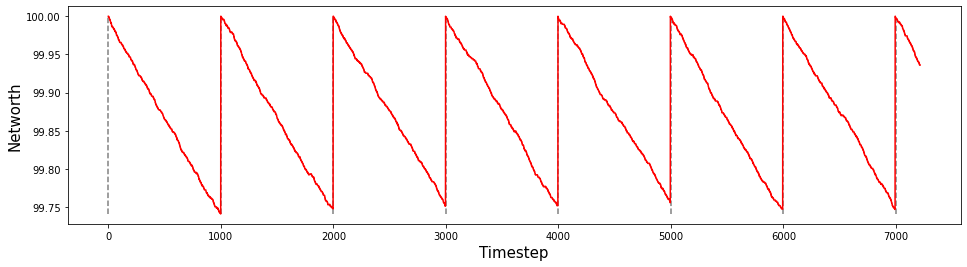

In [ ]:
# Initialize the PPO2
model = PPO2(policy = MlpPolicy, 
             env = environment, 
             noptepochs = 25,
             verbose = 1)

# Train the model
model.learn(total_timesteps = 1000000)

<br>

# THE END!